# Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from scipy import stats 

import lightgbm as lgb
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Helper Functions

In [5]:
def label_encoder(df, column):
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    return df

In [6]:
def label_encoder(df, column):
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    
    return df

def one_hot_encoder(df, column):
 
    df = pd.get_dummies(df, columns=[column])
    return df

def ordinal_encoder(df, column):
    df[column] = df[column].astype("category").cat.codes
    return df

In [7]:


def standardize(data):
  """
  Padroniza um conjunto de dados subtraindo a média e dividindo por
  o desvio padrão.

  Args:
    data: Um conjunto de dados de NumPy.

  Returns:
    Um conjunto de dados padronizado.
  """
  scaler = StandardScaler()
  scaled_data = scaler.fit_transform(data)
  return scaled_data

def normalize(data):
  """
  Normaliza um conjunto de dados dividindo cada valor por seu valor absoluto máximo.

  Args:
    data: Um conjunto de dados de NumPy.

  Returns:
    Um conjunto de dados normalizado.
  """
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled_data = scaler.fit_transform(data)
  return scaled_data

def rescale(data, min_val, max_val):
  """
  Reescala um conjunto de dados para que os valores mínimos e máximos sejam
  min_val e max_val, respectivamente.

  Args:
    data: Um conjunto de dados de NumPy.
    min_val: O valor mínimo do conjunto de dados reescalado.
    max_val: O valor máximo do conjunto de dados reescalado.

  Returns:
    Um conjunto de dados reescalado.
  """
  scaler = MinMaxScaler(feature_range=(min_val, max_val))
  scaled_data = scaler.fit_transform(data)
  return scaled_data


In [8]:
def normalize_column(df, column):
  """
  Normaliza uma coluna de um dataframe.

  Args:
    df: O dataframe a ser normalizado.
    column: O nome da coluna a ser normalizada.

  Returns:
    Um dataframe com a coluna normalizada.
  """

  # Obtém o mínimo e o máximo dos valores na coluna.
  min_value = df[column].min()
  max_value = df[column].max()

  # Normaliza os valores na coluna.
  normalized_column = (df[column] - min_value) / (max_value - min_value)

  # Substitui a coluna original pelo dataframe normalizado.
  df[column] = normalized_column

  return df

In [9]:
###### Cria função para aplicar o teste V de Krammer para verificar a correlação das variáveis categóricas ######

def cramer_v( x, y ):

    # Construindo uma tabela de contingência ou matriz de confusão.
    # Ela verifica todas as combinações das variáveis categóricas e conta o número de ocorrências. Precisamos do resultado em forma de matriz
    cm = pd.crosstab( x, y ).values

    # Soma de todos os valores da matriz de confusão
    n = cm.sum()

    # Número de linhas e colunas
    r, k = cm.shape

    # Cálculo do Qui Quadrado
    # É passado como argumento a tabela de contingência, ou confusion matrix.
    # Estamos interessados no resultado do teste qui quadrado, que é a posição 0
    chi2 = stats.chi2_contingency( cm )[0]

    # Faz a correção do viés do Crammer V, através da correção do Qui quadrado, k e r, sugerida na bibliografia
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)

    # Utiliza a fórmula para o cálculo do Cramer's V e faz o retorno da função
    return np.sqrt( (chi2corr/n) / ( min(kcorr-1, rcorr-1) ) )

########################################################

# Data Load

In [10]:
df_raw = pd.read_csv('data/train.csv')

df_test = pd.read_csv('data/test.csv')

In [11]:
df_raw.head()

,id,Gender,Customer Type,Age,Type of Purchase,Store size,Store distance,InStore wifi,Open/Close time convenient,Easy of online shopping,Store location,Toilet cleaning,Dressing room,Waiting room,Kids entertainment,Seller service,Showroom,Self-Store,Purchase service,Store Service,Cleanliness,Carrier delay in minutes,Delivery delay in minutes,Satisfaction
0,70172,Male,Loyal Customer,13,Personal,Small,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,Neutral or Dissatisfaction
1,5047,Male,disloyal Customer,25,Gift,Large,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,Neutral or Dissatisfaction
2,110028,Female,Loyal Customer,26,Gift,Large,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,Satisfied
3,24026,Female,Loyal Customer,25,Gift,Large,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,Neutral or Dissatisfaction
4,119299,Male,Loyal Customer,61,Gift,Large,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,Satisfied


# 1.0 Descrição dos Dados

In [12]:
df1 = df_raw.copy()

## 1.1 Dimensão dos Dados

In [13]:
df1.shape

(103904, 24)

## 1.2 Tipo dos Dados

In [14]:
df1.dtypes

id                              int64
Gender                         object
Customer Type                  object
Age                             int64
Type of Purchase               object
Store size                     object
Store distance                  int64
InStore wifi                    int64
Open/Close time convenient      int64
Easy of online shopping         int64
Store location                  int64
Toilet cleaning                 int64
Dressing room                   int64
Waiting room                    int64
Kids entertainment              int64
Seller service                  int64
Showroom                        int64
Self-Store                      int64
Purchase service                int64
Store Service                   int64
Cleanliness                     int64
Carrier delay in minutes        int64
Delivery delay in minutes     float64
Satisfaction                   object
dtype: object

In [15]:
df1

,id,Gender,Customer Type,Age,Type of Purchase,Store size,Store distance,InStore wifi,Open/Close time convenient,Easy of online shopping,Store location,Toilet cleaning,Dressing room,Waiting room,Kids entertainment,Seller service,Showroom,Self-Store,Purchase service,Store Service,Cleanliness,Carrier delay in minutes,Delivery delay in minutes,Satisfaction
0,70172,Male,Loyal Customer,13,Personal,Small,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,Neutral or Dissatisfaction
1,5047,Male,disloyal Customer,25,Gift,Large,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,Neutral or Dissatisfaction
2,110028,Female,Loyal Customer,26,Gift,Large,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,Satisfied
3,24026,Female,Loyal Customer,25,Gift,Large,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,Neutral or Dissatisfaction
4,119299,Male,Loyal Customer,61,Gift,Large,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,Satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,94171,Female,disloyal Customer,23,Gift,Medium,192,2,1,2,3,2,2,2,2,3,1,4,2,3,2,3,0.0,Neutral or Dissatisfaction
103900,73097,Male,Loyal Customer,49,Gift,Large,2347,4,4,4,4,2,4,5,5,5,5,5,5,5,4,0,0.0,Satisfied
103901,68825,Male,disloyal Customer,30,Gift,Large,1995,1,1,1,3,4,1,5,4,3,2,4,5,5,4,7,14.0,Neutral or Dissatisfaction
103902,54173,Female,disloyal Customer,22,Gift,Medium,1000,1,1,1,5,1,1,1,1,4,5,1,5,4,1,0,0.0,Neutral or Dissatisfaction


## 1.3 Check Na

In [16]:
df1.isna().sum()

id                              0
Gender                          0
Customer Type                   0
Age                             0
Type of Purchase                0
Store size                      0
Store distance                  0
InStore wifi                    0
Open/Close time convenient      0
Easy of online shopping         0
Store location                  0
Toilet cleaning                 0
Dressing room                   0
Waiting room                    0
Kids entertainment              0
Seller service                  0
Showroom                        0
Self-Store                      0
Purchase service                0
Store Service                   0
Cleanliness                     0
Carrier delay in minutes        0
Delivery delay in minutes     310
Satisfaction                    0
dtype: int64

## 1.4 Análise Estatística

In [17]:
num_attributes = df1.select_dtypes(include=['int64','float64'])

In [18]:
# Get the numerical attributes

# Central Tendency - mean, median 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# percentiles
p25 = pd.DataFrame( num_attributes.apply( lambda x: np.percentile(x, 25) ) ).T 
p75 = pd.DataFrame( num_attributes.apply( lambda x: np.percentile(x, 75) ) ).T 
p99 = pd.DataFrame( num_attributes.apply( lambda x: np.percentile(x, 99) ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6, p25, p75, p99] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis', 'p25', 'p75', 'p99']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis,p25,p75,p99
0,id,1.0,129880.0,129879.0,64924.210502,64856.5,37463.631970,0.002864,-1.198440,32533.75,97368.25,128588.97
1,Age,7.0,85.0,78.0,39.379706,40.0,15.114891,-0.004516,-0.719568,27.00,51.00,70.00
2,Store distance,31.0,4983.0,4952.0,1189.448375,843.0,997.142482,1.109466,0.268535,414.00,1743.00,3882.00
3,InStore wifi,0.0,5.0,5.0,2.729683,3.0,1.327823,0.040408,-0.846170,2.00,4.00,5.00
4,Open/Close time convenient,0.0,5.0,5.0,3.060296,3.0,1.525068,-0.334399,-1.037767,2.00,4.00,5.00
5,Easy of online shopping,0.0,5.0,5.0,2.756901,3.0,1.398923,-0.018294,-0.910346,2.00,4.00,5.00
6,Store location,0.0,5.0,5.0,2.976883,3.0,1.277615,-0.058889,-1.030283,2.00,4.00,5.00
7,Toilet cleaning,0.0,5.0,5.0,3.202129,3.0,1.329526,-0.151279,-1.145453,2.00,4.00,5.00
8,Dressing room,0.0,5.0,5.0,3.250375,3.0,1.349502,-0.453852,-0.702006,2.00,4.00,5.00
9,Waiting room,0.0,5.0,5.0,3.439396,4.0,1.319081,-0.482775,-0.925702,2.00,5.00,5.00


# 2.0 Feature Engineering

In [19]:
df2 = df1.copy()

In [136]:
# media_idade = df2['Age'].mean()

# # Criando a nova feature de diferença de idade
# df2['Age difference'] = np.abs(df2['Age'] - media_idade)

# # Criando a nova feature de atraso total
# df2['Total delay'] = df2['Carrier delay in minutes'] + df2['Delivery delay in minutes']


In [137]:
# df_test['Age difference'] = df_test['Age'] - media_idade

# # Criando a nova feature de atraso total
# df_test['Total delay'] = df_test['Carrier delay in minutes'] + df_test['Delivery delay in minutes']

In [138]:
# Criar feature online_presencial

# df2['presencial_online'] = df2.apply()

In [139]:
# df2['presencial_online'] = df2.apply(lambda x: 1 if x['Delivery delay in minutes'] > 0 else 1,axis=1)

In [140]:
# df2[['id', 'Satisfaction']].loc[df2['Delivery delay in minutes'].isna()].groupby('Satisfaction').count()

In [20]:
df2.isna().sum()

id                              0
Gender                          0
Customer Type                   0
Age                             0
Type of Purchase                0
Store size                      0
Store distance                  0
InStore wifi                    0
Open/Close time convenient      0
Easy of online shopping         0
Store location                  0
Toilet cleaning                 0
Dressing room                   0
Waiting room                    0
Kids entertainment              0
Seller service                  0
Showroom                        0
Self-Store                      0
Purchase service                0
Store Service                   0
Cleanliness                     0
Carrier delay in minutes        0
Delivery delay in minutes     310
Satisfaction                    0
dtype: int64

# 3.0 EDA

In [21]:
df3 = df2.copy()

In [22]:
df3[['id','Satisfaction']].groupby('Satisfaction').count()

,id
Satisfaction,
Neutral or Dissatisfaction,58879
Satisfied,45025


Variável resposta: 
- Satisfação Neutra ou Não satisfeito: 0
- Satisfeito: 1

In [23]:
# Transforma variável resposta em numérica
df2['Satisfaction_num'] = df2['Satisfaction'].apply( lambda x: 0 if x == 'Neutral or Dissatisfaction' else 1 )

In [24]:
# Separa o dataset em variáveis categóricas e numéricas
num_attributes = df2.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df2.select_dtypes( exclude=['int64', 'float64'] )

In [25]:
# Analise dos dados categóricos
cat_attributes.apply( lambda x: x.unique().shape[0] )

Gender              2
Customer Type       2
Type of Purchase    2
Store size          3
Satisfaction        2
dtype: int64

In [26]:
a = cat_attributes
a

,Gender,Customer Type,Type of Purchase,Store size,Satisfaction
0,Male,Loyal Customer,Personal,Small,Neutral or Dissatisfaction
1,Male,disloyal Customer,Gift,Large,Neutral or Dissatisfaction
2,Female,Loyal Customer,Gift,Large,Satisfied
3,Female,Loyal Customer,Gift,Large,Neutral or Dissatisfaction
4,Male,Loyal Customer,Gift,Large,Satisfied
...,...,...,...,...,...
103899,Female,disloyal Customer,Gift,Medium,Neutral or Dissatisfaction
103900,Male,Loyal Customer,Gift,Large,Satisfied
103901,Male,disloyal Customer,Gift,Large,Neutral or Dissatisfaction
103902,Female,disloyal Customer,Gift,Medium,Neutral or Dissatisfaction


Pergunta 1: O genero influencia na satisfação?

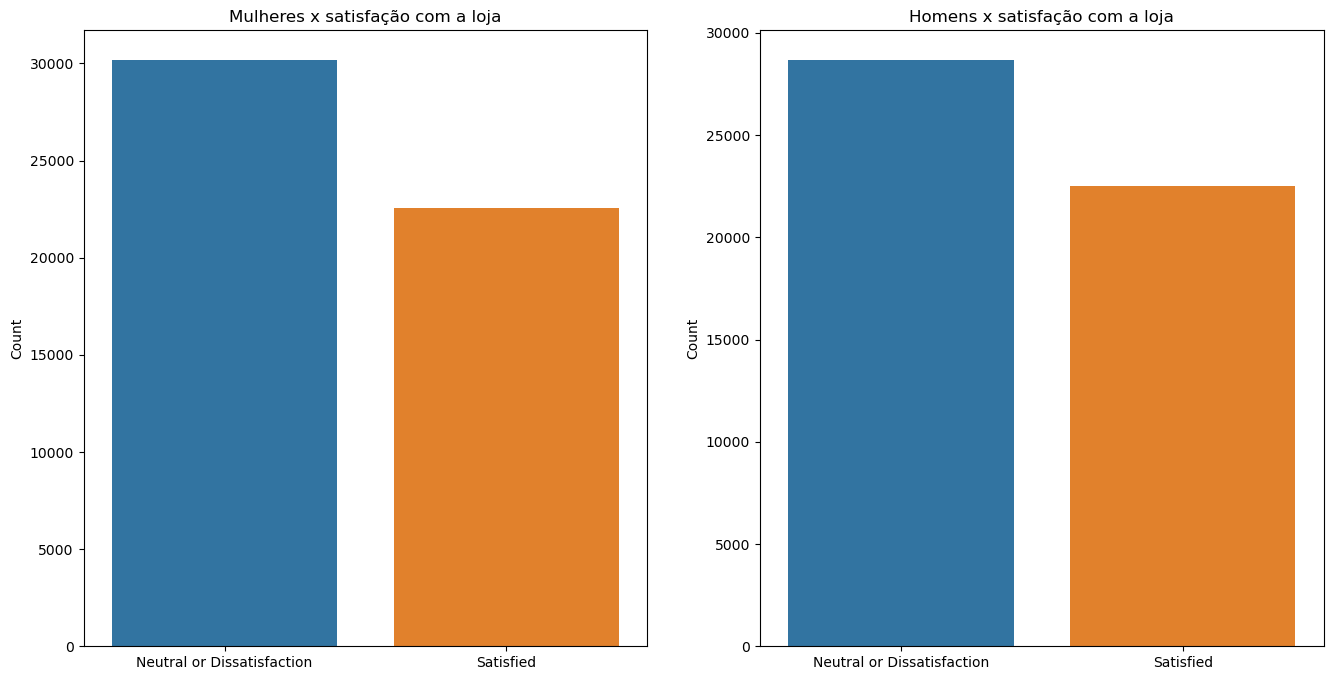

In [27]:
# Filtra no df genero dos clientes
fem = df2[df2['Gender'] == 'Female'] 
man = df2[df2['Gender'] == 'Male'] 


plt.figure( figsize=(16, 8) )
plt.subplot( 1, 2, 1 )

aux1= fem[['Gender', 'Satisfaction']].groupby( 'Satisfaction' ).count().reset_index()
sns.barplot( x='Satisfaction', y='Gender', data=aux1)

# Adicione rótulos e título aos eixos
plt.xlabel('')
plt.ylabel('Count')
plt.title('Mulheres x satisfação com a loja')

plt.subplot( 1, 2, 2 )

aux2= man[['Gender', 'Satisfaction']].groupby( 'Satisfaction' ).count().reset_index()
sns.barplot( x='Satisfaction', y='Gender', data=aux2)

# Adicione rótulos e título aos eixos
plt.xlabel('')
plt.ylabel('Count')
plt.title('Homens x satisfação com a loja')

plt.show()

### Resposta: não há grande influência do gênero sobre a avaliação da loja. 

### Pergunta 2: Há influência do tamanho da loja na satisfação do cliente?

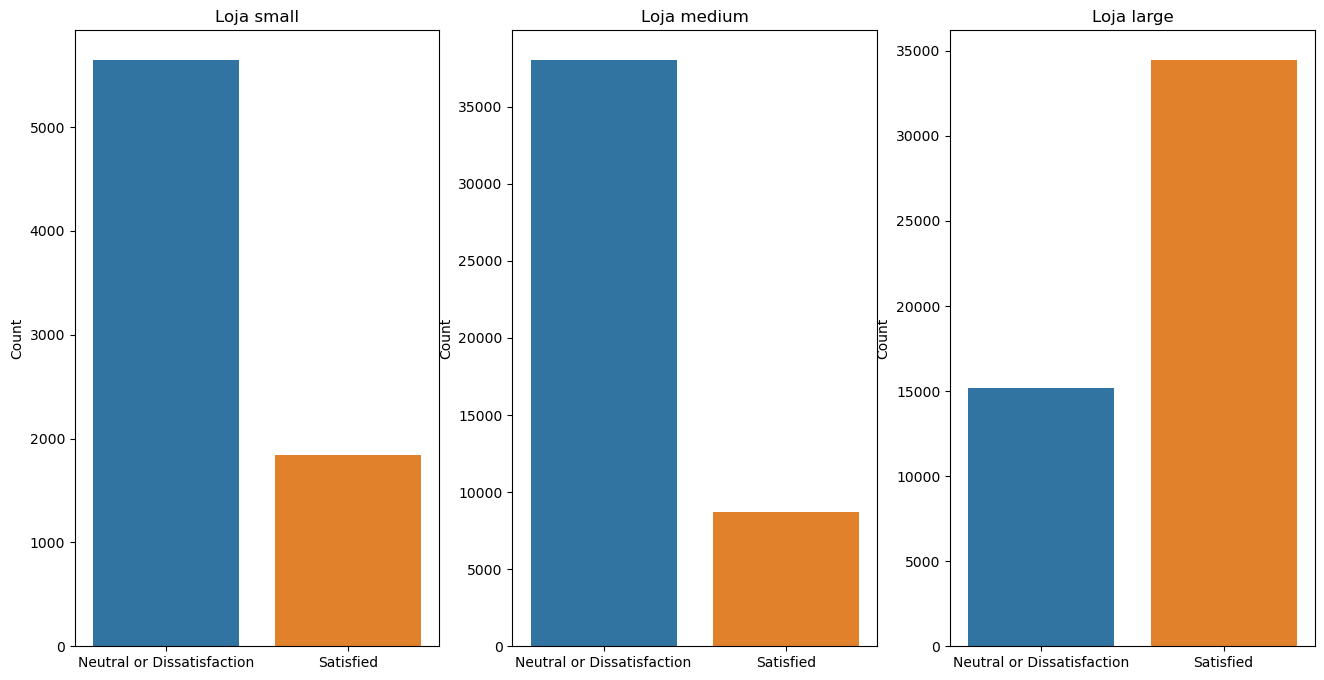

In [28]:
# Filtra no df os tipos de loja
small = df2[df2['Store size'] == 'Small'] 
medium = df2[df2['Store size'] == 'Medium']
large = df2[df2['Store size'] == 'Large'] 

plt.figure( figsize=(16, 8) )
plt.subplot( 1, 3, 1 )

small = small[['Store size', 'Satisfaction']].groupby('Satisfaction').count().reset_index()
sns.barplot( x='Satisfaction', y='Store size', data=small)

# Adicione rótulos e título aos eixos
plt.xlabel('')
plt.ylabel('Count')
plt.title('Loja small')

plt.subplot( 1, 3, 2 )

medium = medium[['Store size', 'Satisfaction']].groupby('Satisfaction').count().reset_index()
sns.barplot( x='Satisfaction', y='Store size', data=medium)

# Adicione rótulos e título aos eixos
plt.xlabel('')
plt.ylabel('Count')
plt.title('Loja medium')


plt.subplot( 1, 3, 3 )
large = large[['Store size', 'Satisfaction']].groupby('Satisfaction').count().reset_index()
sns.barplot( x='Satisfaction', y='Store size', data=large)

# Adicione rótulos e título aos eixos
plt.xlabel('')
plt.ylabel('Count')
plt.title('Loja large')

plt.show()

### Resposta: sim, os clientes das lojas large estão mais satisfeitos. 
- Isso pode se relacionar tanto à variedade de produtos como a melhores instalações e serviços nas lojas large. 

### Pergunta 3: O tipo de compra (se para presente ou para si próprio) influencia na satisfação?

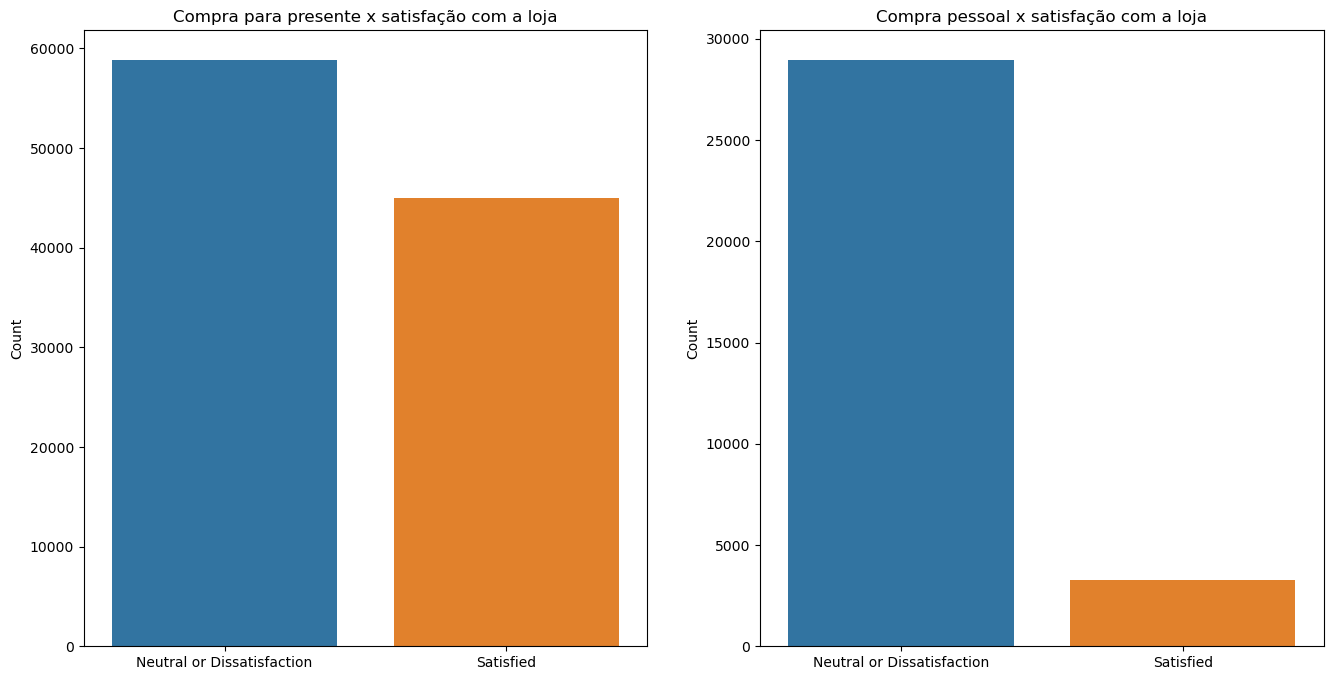

In [29]:
# Filtra no df distancia do competidor e vendas e agrupa por distância do competidor, exibindo uma soma
aux1 = df2[df2['Store size'] == 'Gift'] 
aux2 = df2[df2['Type of Purchase'] != 'Gift'] 


plt.figure( figsize=(16, 8) )
plt.subplot( 1, 2, 1 )

aux1= df2[['Type of Purchase', 'Satisfaction']].groupby( 'Satisfaction' ).count().reset_index()
sns.barplot( x='Satisfaction', y='Type of Purchase', data=aux1)

# Adicione rótulos e título aos eixos
plt.xlabel('')
plt.ylabel('Count')
plt.title('Compra para presente x satisfação com a loja')

plt.subplot( 1, 2, 2 )

aux2= aux2[['Type of Purchase', 'Satisfaction']].groupby( 'Satisfaction' ).count().reset_index()
sns.barplot( x='Satisfaction', y='Type of Purchase', data=aux2)

# Adicione rótulos e título aos eixos
plt.xlabel('')
plt.ylabel('Count')
plt.title('Compra pessoal x satisfação com a loja')

plt.show()

### Resposta: Sim, há influência do tipo de compra na satisfação do cliente. 

- Possíveis explicações: o cliente que compra para ele mesmo tende a utilizar estruturas da loja como provadores, banheiros e área para crianças por mais tempo que aqueles que compram para outras pessoas. 

### Correlação entre variáveis numéricas

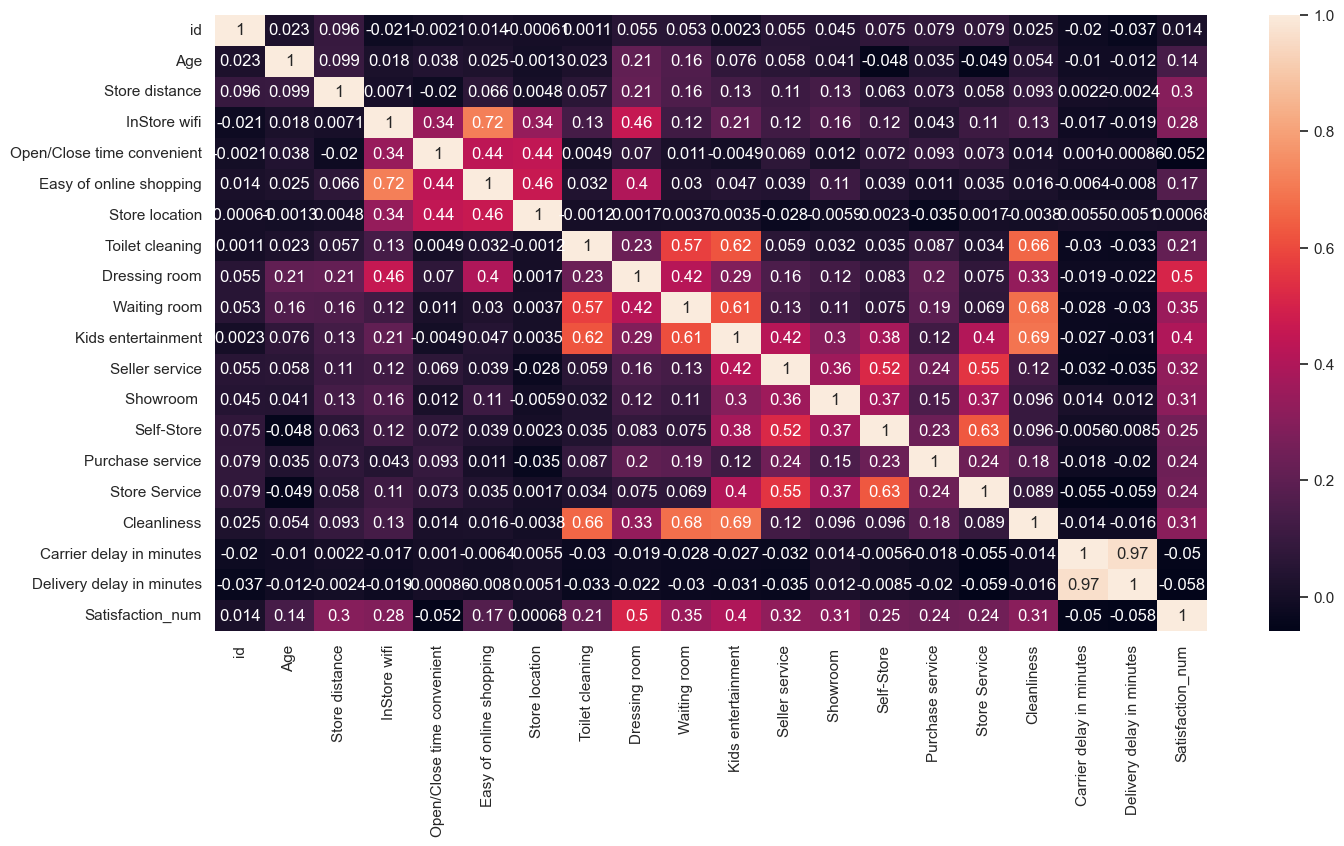

In [30]:
# Faz o gráfico de correlação de pearson entre todas as variáveis numéricas
correlation = num_attributes.corr( method='pearson' )

# Plota mapa de calor com as correlações
plt.figure( figsize=(16, 8) )
sns.set_theme( style='darkgrid' )
sns.heatmap( correlation, annot=True );

In [48]:
# Colunas a serem retiradas devido à correlação com outras
#drop_colums = ['Gender', 'Toilet cleaning','Waiting room', 'Easy of online shopping']

### Correlação entre variáveis categóricas

- Uso do Teste V de Krammer

In [31]:
# Aplica a função do teste V de Krammer nas combinações possíveis
a1 = cramer_v( a['Gender'], a['Gender'] )
a2 = cramer_v( a['Gender'], a['Customer Type'] )
a3 = cramer_v( a['Gender'], a['Type of Purchase'] )
a4 = cramer_v( a['Gender'], a['Store size'] )
a5 = cramer_v( a['Gender'], a['Satisfaction'] )

a6 = cramer_v( a['Customer Type'], a['Gender'] )
a7 = cramer_v( a['Customer Type'], a['Customer Type'] )
a8 = cramer_v( a['Customer Type'], a['Type of Purchase'] )
a9 = cramer_v( a['Customer Type'], a['Store size'] )
a10 = cramer_v( a['Customer Type'], a['Satisfaction'] )

a11 = cramer_v( a['Type of Purchase'], a['Gender'] )
a12 = cramer_v( a['Type of Purchase'], a['Customer Type'] )
a13 = cramer_v( a['Type of Purchase'], a['Type of Purchase'] )
a14 = cramer_v( a['Type of Purchase'], a['Store size'] )
a15 = cramer_v( a['Type of Purchase'], a['Satisfaction'] )

a16 = cramer_v( a['Store size'], a['Gender'] )
a17 = cramer_v( a['Store size'], a['Customer Type'] )
a18 = cramer_v( a['Store size'], a['Type of Purchase'] )
a19 = cramer_v( a['Store size'], a['Store size'] )
a20 = cramer_v( a['Store size'], a['Satisfaction'] )

a21 = cramer_v( a['Satisfaction'], a['Gender'] )
a22 = cramer_v( a['Satisfaction'], a['Customer Type'] )
a23 = cramer_v( a['Satisfaction'], a['Type of Purchase'] )
a24 = cramer_v( a['Satisfaction'], a['Store size'] )
a25 = cramer_v( a['Satisfaction'], a['Satisfaction'] )

# Cria dataframe com uma tabela das possibilidades de combinação acima
d = pd.DataFrame( {'Gender': [a1, a2, a3, a4, a5],
               'Customer Type': [a6, a7, a8, a9, a10],
               'Type of Purchase': [a11, a12, a13, a14, a15],
               'Store size': [a16, a17, a18, a19, a20], 
               'Satisfaction': [a21, a22, a23, a24, a25]} )


# Para melhor visualização, atribui como index do df as colunas da tabela
d = d.set_index( d.columns )

# Exibe o dataset final
d

,Gender,Customer Type,Type of Purchase,Store size,Satisfaction
Gender,0.999986,0.031707,0.006888,0.013187,0.012192
Customer Type,0.031707,0.999973,0.308308,0.123508,0.187614
Type of Purchase,0.006888,0.308308,0.999982,0.554057,0.448982
Store size,0.013187,0.123508,0.554057,1.000010,0.504752
Satisfaction,0.012192,0.187614,0.448982,0.504752,0.999985


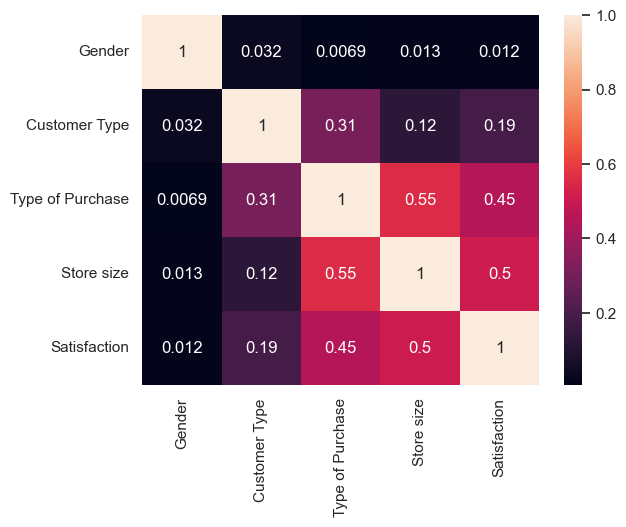

In [32]:
# Cria mapa de calor com a correlaçao das variáveis categóricas do df
sns.heatmap(d, annot=True);

Recomendação: retirar a variável Gender do modelo final. 

# 4.0 Filtragem dos Dados

In [33]:
df4 = df3.copy()

## 4.1 Filtragem de Colunas

In [47]:
df4 = df4.drop(columns=['Delivery delay in minutes'])

df_test = df_test.drop(columns=['Delivery delay in minutes'])

df4 = df4.dropna()

df_test = df_test.dropna()

## 4.2 Filtragens de Linhas

In [48]:
median_delay = np.median(df4['Carrier delay in minutes'])
median_age = np.median(df4['Age'])

print(median_age)

df4['Carrier delay in minutes'] = df4['Carrier delay in minutes'].apply(lambda x: median_delay if x > 181.97 else x)

# df3.loc[df3['Carrier delay in minutes'] <= 181.97]
df4['Age'] = df4['Age'].apply(lambda x: median_age if x <= 15 else x)


#### Teste ######

df_test['Carrier delay in minutes'] = df_test['Carrier delay in minutes'].apply(lambda x: median_delay if x > 181.97 else x)

# df3.loc[df3['Carrier delay in minutes'] <= 181.97]
df_test['Age'] = df_test['Age'].apply(lambda x: median_age if x <= 15 else x)

40.0


# 5.0 Pré Processamento

In [49]:
df5 = df4.copy()

## Encoding

In [50]:
# Gender
df5 = label_encoder(df5, 'Gender')

# Customer Type
df5 = label_encoder(df5, 'Customer Type')

# Type of Purchase
df5 = label_encoder(df5, 'Type of Purchase')

# Store size
df5 = label_encoder(df5, 'Store size')

# Store size
df5 = label_encoder(df5, 'Satisfaction')

In [51]:
df_test = label_encoder(df_test, 'Gender')


# Customer Type
df_test = label_encoder(df_test, 'Customer Type')

# Type of Purchase
df_test = label_encoder(df_test, 'Type of Purchase')

# Store size
df_test = label_encoder(df_test, 'Store size')

In [52]:
df_test

,id,Gender,Customer Type,Age,Type of Purchase,Store size,Store distance,InStore wifi,Open/Close time convenient,Easy of online shopping,Store location,Toilet cleaning,Dressing room,Waiting room,Kids entertainment,Seller service,Showroom,Self-Store,Purchase service,Store Service,Cleanliness,Carrier delay in minutes
0,19556,0,0,52.0,0,1,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50.0
1,90035,0,0,36.0,0,0,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0.0
2,12360,1,1,20.0,0,1,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0.0
3,77959,1,0,44.0,0,0,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0.0
4,36875,0,0,49.0,0,1,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25971,78463,1,1,34.0,0,0,526,3,3,3,1,4,3,4,4,3,2,4,4,5,4,0.0
25972,71167,1,0,23.0,0,0,646,4,4,4,4,4,4,4,4,4,5,5,5,5,4,0.0
25973,37675,0,0,17.0,1,1,828,2,5,1,5,2,1,2,2,4,3,4,5,4,2,0.0
25974,90086,1,0,40.0,0,0,1127,3,3,3,3,4,4,4,4,3,2,5,4,5,4,0.0


# 6.0 Feature Selection

## 6.1 Feature Importance

In [53]:
df6 = df5.copy()

In [156]:
# Features selecionadas pelo algoritmo Boruta

# columns_importance = ['Type of Purchase','InStore wifi','Customer Type','Self-Store',
#      'Dressing room','Store Service','Purchase service','Waiting room','Cleanliness',
#      'Store size','Store location','Seller service','Satisfaction']
# df6 = df6[columns_importance]
# df_test = df_test[['id','Type of Purchase','InStore wifi','Customer Type','Self-Store',
#      'Dressing room','Store Service','Purchase service','Waiting room','Cleanliness',
#      'Store size','Store location','Seller service',]]

In [157]:
# df6 = df6[['Customer Type',
#         'Type of Purchase',
#         'Store size',
#         'Store distance',
#         'InStore wifi',
#         'Store location',
#         'Dressing room',
#         'Kids entertainment',
#         'Self-Store',
#         'Purchase service',
#         'Store Service', 'Satisfaction']]

# df_test = df_test[['id','Customer Type',
#         'Type of Purchase',
#         'Store size',
#         'Store distance',
#         'InStore wifi',
#         'Store location',
#         'Dressing room',
#         'Kids entertainment',
#         'Self-Store',
#         'Purchase service',
#         'Store Service']]

#drop_colums = ['Gender', 'Toilet cleaning','Waiting room', 'Easy of online shopping']

# df6 = df6.drop(columns=drop_colums)


# 7.0 Machine Learning

In [54]:
df7 = df6.copy()

In [55]:
df7.head()

,id,Gender,Customer Type,Age,Type of Purchase,Store size,Store distance,InStore wifi,Open/Close time convenient,Easy of online shopping,Store location,Toilet cleaning,Dressing room,Waiting room,Kids entertainment,Seller service,Showroom,Self-Store,Purchase service,Store Service,Cleanliness,Carrier delay in minutes,Satisfaction
0,70172,1,0,40.0,1,2,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25.0,0
1,5047,1,1,25.0,0,0,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1.0,0
2,110028,0,0,26.0,0,0,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0.0,1
3,24026,0,0,25.0,0,0,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11.0,0
4,119299,1,0,61.0,0,0,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0.0,1


In [72]:
# Separar variáveis explicativas e resposta no df

# X: dados sem a variável resposta
X = df7.drop(columns=['Satisfaction'])

#y: apenas variável resposta
y = df7['Satisfaction']

df_test_aux = df_test.drop(columns=['id'])

# Separa dados de treino e teste. 20% para teste
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

## 7.1 Random Forest

In [57]:
# model definition
rf_model = RandomForestClassifier(n_estimators=100)

# train model
rf_model.fit(X_train, y_train)

#predict
yhat_rf = rf_model.predict(X_test)

## 7.1.1 Model Performance

In [58]:

def metrics(y_real, y_hat, name_model):
  """
  Calcula as métricas de acurácia, precisão e F1-score.

  Args:
    y_real: Os rótulos reais.
    y_hat: As previsões do modelo.

  Returns:
    Um DataFrame com as métricas.
  """

  accuracy = accuracy_score(y_real, y_hat)
  precision = precision_score(y_real, y_hat, average="micro")
  f1 = f1_score(y_real, y_hat, average="micro")

  df = pd.DataFrame({
    "Nome Modelo": name_model,
    "Acurácia": accuracy,
    "Precisão": precision,
    "F1": f1
  }, index=[0])
  return df

metrics_rf = metrics( y_test, yhat_rf, 'Random Forest' )

In [59]:
metrics_rf

,Nome Modelo,Acurácia,Precisão,F1
0,Random Forest,0.961359,0.961359,0.961359


## 7.2 XGBoost

In [60]:
from xgboost                       import XGBClassifier
import lightgbm as lgbm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# model's metrics
from sklearn.metrics        import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,\
confusion_matrix, matthews_corrcoef, make_scorer, roc_curve, precision_recall_curve

In [61]:
# instantiate
xgb_model = XGBClassifier(n_estimators=500, random_state = 42, n_jobs=-1, 
                        eval_metric='logloss')

#model training
xgb_model.fit(X_train, y_train)

#predict
yhat_xbg = xgb_model.predict(X_test)

### 7.2.1 Model performance

In [62]:
# accuracy
metrics_xgb = metrics( y_test, yhat_xbg, 'XGBOOST' )

In [63]:
metrics_xgb

,Nome Modelo,Acurácia,Precisão,F1
0,XGBOOST,0.960493,0.960493,0.960493


## 7.3 LGBM

In [64]:
# Definition
lgbm_model = lgbm.LGBMClassifier(n_estimators=500, random_state = 42, n_jobs=-1)

#model training
lgbm_model.fit(X_train, y_train)

# Predict
yhat_lgbm = lgbm_model.predict(X_test)


## 7.3.1 Model Performance

In [65]:

metrics_lgbm = metrics( y_test, yhat_lgbm, 'LGBM' )
metrics_lgbm

,Nome Modelo,Acurácia,Precisão,F1
0,LGBM,0.962851,0.962851,0.962851


## 7.4 Nayve Bayes

In [66]:
# Definition
nb_model = GaussianNB()


#model training
nb_model.fit(X_train, y_train)

#Predict
yhat_nb = nb_model.predict(X_test)

## 7.4.1 Nayve Bayes

In [67]:
metrics_nb = metrics( y_test, yhat_nb, 'Nayve Bayes' )
metrics_nb

,Nome Modelo,Acurácia,Precisão,F1
0,Nayve Bayes,0.804533,0.804533,0.804533


## 7.5 Compare Model's Performance

In [68]:
df_result = pd.concat([metrics_nb, metrics_lgbm, metrics_xgb, metrics_rf])
df_result = df_result.sort_values('Precisão', ascending=False)
df_result

,Nome Modelo,Acurácia,Precisão,F1
0,LGBM,0.962851,0.962851,0.962851
0,Random Forest,0.961359,0.961359,0.961359
0,XGBOOST,0.960493,0.960493,0.960493
0,Nayve Bayes,0.804533,0.804533,0.804533


## Conclusão: modelo com melhor acurácia: LGBM - 96,285%

# 8.0 Hiper Parameter Fine Tunning

In [1730]:
# import numpy as np

# from sklearn.model_selection import GridSearchCV, StratifiedKFold
# from sklearn.metrics import precision_score, make_scorer

# # Definindo o classificador LGBM
# lgbm_model = lgbm.LGBMClassifier(random_state=42)

# # Definindo os parâmetros a serem testados
# param_grid = {
#     'n_estimators': [100, 500, 1000],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'max_depth': [3, 5, 7]
# }

# # Definindo a estratégia de validação cruzada
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Definindo a métrica de precisão (precision) com average='micro'
# scorer = make_scorer(precision_score, average='micro')

# # Realizando a busca dos melhores parâmetros com validação cruzada
# grid_search = GridSearchCV(lgbm_model, param_grid=param_grid, cv=cv, scoring=scorer)
# grid_search.fit(X, y)

# # Obtendo os melhores parâmetros e o melhor resultado
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print("Melhores parâmetros encontrados:")
# print(best_params)
# print("Melhor pontuação (precision micro) encontrada:")
# print(best_score)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 36020, number of negative: 47103
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 83123, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.433334 -> initscore=-0.268262
[LightGBM] [Info] Start training from score -0.268262


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Foun

## 8.1 Melhores parâmetros para o LGBM 

In [1733]:
# print("Melhores parâmetros encontrados:")
# print(best_params)
# print("Melhor pontuação (precision micro) encontrada:")
# print(best_score)

Melhores parâmetros encontrados:
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}
Melhor pontuação (precision micro) encontrada:
0.965429613626388


## Após Fine Tunning: Acurácia de 96,542%

# 9.0 Final Model

In [69]:
X_final = pd.concat([X_train, X_test])
y_final = pd.concat([y_train, y_test])

X_final = X_final.drop(columns=['id'])

In [70]:
# Definition
lgbm_model_final = lgbm.LGBMClassifier(learning_rate = 0.1, max_depth =  7, n_estimators = 500, random_state = 42, n_jobs=-1)

# model training
lgbm_model_final.fit(X_final, y_final)

# Predict
#yhat_lgbm = lgbm_model_final.predict(X_test)

LGBMClassifier(max_depth=7, n_estimators=500, random_state=42)

## 9.1 Performance Test

In [73]:
# Faz a predição com os dados de teste 
pred_sub = lgbm_model_final.predict(df_test_aux)

In [74]:
# Inclui a coluna com as predições no df final para submissão 
df_test['Satisfaction'] = pred_sub

In [425]:
# df_test.columns = ['ID', 'Gender', 'Customer Type', 'Age', 'Type of Purchase',
#        'Store size', 'Store distance', 'InStore wifi',
#        'Open/Close time convenient', 'Easy of online shopping',
#        'Store location', 'Toilet cleaning', 'Dressing room', 'Waiting room',
#        'Kids entertainment', 'Seller service', 'Showroom ', 'Self-Store',
#        'Purchase service', 'Store Service', 'Cleanliness',
#        'Carrier delay in minutes', 'Satisfaction']

In [426]:
#df_test[['ID', 'Satisfaction']].rename({'id': 'ID', 'Satisfaction':'Satisfaction'}).to_csv('submission.csv', index=False, sep=';')

In [75]:
df_test.shape

(25976, 23)

In [76]:
df_final = pd.concat([df_test.id, pd.Series(pred_sub, name = 'Satisfaction')], axis=1)

In [77]:
# Exibe df final com as predições
df_final.head()

,id,Satisfaction
0,19556,1
1,90035,1
2,12360,0
3,77959,1
4,36875,0


In [78]:
# Salva o df final para submissão no Kaggle
df_final.to_csv('C:/Users/giova/Principal/DataScience/ComunidadeDS/repos/hackday/submissao/submission.csv', index=False)

Acurácia final no Kaggle: 94,713%

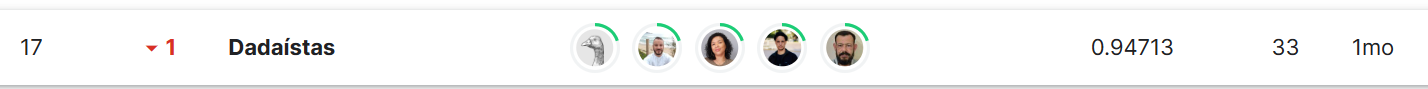

In [79]:
# Exibir imagem do resultado no Kaggle 
Image( 'c:/Users/giova/Principal/DataScience/ComunidadeDS/repos/hackday/data/result_final.png' )